In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, glob

In [2]:
img_list = sorted(glob.glob('./finding-lungs-in-ct-data/2d_images/*.tif'))
mask_list = sorted(glob.glob('./finding-lungs-in-ct-data/2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


In [3]:
IMG_SIZE = 512

image = []
mask = []

for i, img_path in enumerate(img_list):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (int(IMG_SIZE/2), int(IMG_SIZE/2)), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(1, int(IMG_SIZE/2), int(IMG_SIZE/2)) / 255
    image.append(img)
    
for i, img_path in enumerate(mask_list):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (int(IMG_SIZE/2), int(IMG_SIZE/2)), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(1, int(IMG_SIZE/2), int(IMG_SIZE/2)) / 255
    mask.append(img)

image = np.array(image)
mask = np.array(mask)
    
print(image.shape, mask.shape)

(267, 1, 256, 256) (267, 1, 256, 256)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [5]:
x_train  =  torch.FloatTensor(image)
y_train  =  torch.FloatTensor(mask)

In [6]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [240, 27])

In [7]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

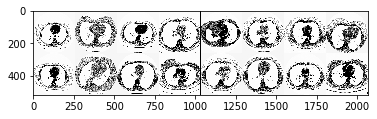

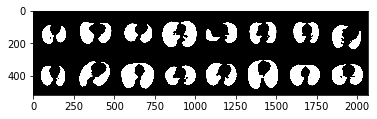

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.dense = nn.Conv2d(128, 128, 1)
        
        self.up5 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.up6 = nn.Upsample(scale_factor=2)
        self.conv6 = nn.Conv2d(128, 64, 3, padding=1)
        
        self.up7 = nn.Upsample(scale_factor=2)
        self.conv7 = nn.Conv2d(64, 32, 3, padding=1)
        
        self.up8 = nn.Upsample(scale_factor=2)
        self.conv8 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = self.dense(x)
        
        x = self.conv5(F.sigmoid(self.up5(x)))
        x = self.conv6(F.sigmoid(self.up6(x)))
        x = self.conv7(F.sigmoid(self.up7(x)))
        x = self.conv8(F.sigmoid(self.up8(x)))
        return x


net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (up5): Upsample(scale_factor=2.0, mode=nearest)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up6): Upsample(scale_factor=2.0, mode=nearest)
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up7): Upsample(sca

In [10]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.0005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [11]:
train_losses, val_losses, accuracy = [], [], []
epochs = 100

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        
        with torch.no_grad():
            cnt = 0
            
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_outputs = net(val_image)
                
                val_loss += criterion(val_outputs, val_label)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} ".format(val_loss/len(val_loader))
             )

print('Finished Training')

C:\Users\nicet\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/100 ||  Training Loss: 0.56646 ||  Val Loss: 0.53372 
Epoch: 2/100 ||  Training Loss: 0.55063 ||  Val Loss: 0.53746 
Epoch: 3/100 ||  Training Loss: 0.54924 ||  Val Loss: 0.53943 
Epoch: 4/100 ||  Training Loss: 0.54738 ||  Val Loss: 0.53240 
Epoch: 5/100 ||  Training Loss: 0.53187 ||  Val Loss: 0.49636 
Epoch: 6/100 ||  Training Loss: 0.46485 ||  Val Loss: 0.42552 
Epoch: 7/100 ||  Training Loss: 0.40979 ||  Val Loss: 0.39798 
Epoch: 8/100 ||  Training Loss: 0.35526 ||  Val Loss: 0.35294 
Epoch: 9/100 ||  Training Loss: 0.30661 ||  Val Loss: 0.29097 
Epoch: 10/100 ||  Training Loss: 0.25073 ||  Val Loss: 0.24896 
Epoch: 11/100 ||  Training Loss: 0.20813 ||  Val Loss: 0.19844 
Epoch: 12/100 ||  Training Loss: 0.17951 ||  Val Loss: 0.18302 
Epoch: 13/100 ||  Training Loss: 0.16493 ||  Val Loss: 0.18448 
Epoch: 14/100 ||  Training Loss: 0.14543 ||  Val Loss: 0.17646 
Epoch: 15/100 ||  Training Loss: 0.13019 ||  Val Loss: 0.13714 
Epoch: 16/100 ||  Training Loss: 0.13061 ||  Val 

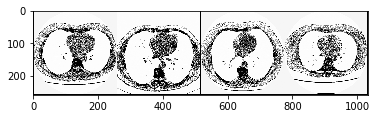

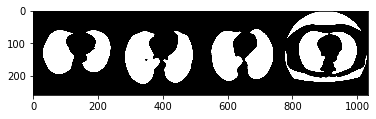

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


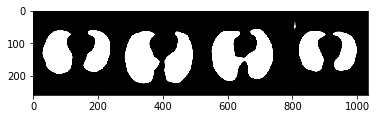

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(val_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))
images, labels = images.to(device), labels.to(device)
results = net(images)
results = results.cpu().detach()
imshow(torchvision.utils.make_grid(results))

In [17]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

print(train_losses.shape, val_losses.shape)

(100,) (100,)


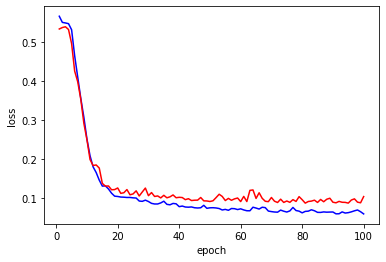

In [19]:
x = np.arange(1, 101, 1)

plt.plot(x, train_losses,'b', label='train loss')
plt.plot(x, val_losses,'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()